<a href="https://colab.research.google.com/github/aulialigar/model_braintumor/blob/main/Autoencoder_Brain_Tumor_Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Drive and Depedency

In [ ]:
# from google.colab import drive
# drive._mount('/content/drive')
# CHANGE BASED ROOT DIR
# %cd '/content/drive/My Drive/BrainTumorRetrieval'

In [ ]:
!wget --no-check-certificate \
  https://github.com/aulialigar/braintumor-image/archive/refs/heads/dataset-dan-model.zip\
  -O /tmp/BrainTumorRetrieval.zip   

--2022-01-18 16:08:02--  https://github.com/aulialigar/braintumor-image/archive/refs/heads/dataset-dan-model.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/aulialigar/braintumor-image/zip/refs/heads/dataset-dan-model [following]
--2022-01-18 16:08:02--  https://codeload.github.com/aulialigar/braintumor-image/zip/refs/heads/dataset-dan-model
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/BrainTumorRetrieval.zip’

/tmp/BrainTumorRetr     [            <=>     ] 838.52M  14.8MB/s    in 37s     

2022-01-18 16:08:40 (22.4 MB/s) - ‘/tmp/BrainTumorRetrieval.zip’ saved [879249415]



In [ ]:
# !unzip \*.zip &> /dev/null && rm *.zip
import zipfile
zip_ref = zipfile.ZipFile('/tmp/BrainTumorRetrieval.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
import os
base_dir = '/tmp/braintumor-image-dataset-dan-model/BrainTumorRetrieval'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

train_glioma_dir = os.path.join(train_dir, 'glioma')
train_meningioma_dir = os.path.join(train_dir, 'meningioma')
train_pituitary_dir = os.path.join(train_dir, 'pituitary')

test_glioma_dir = os.path.join(test_dir, 'glioma')
test_meningioma_dir = os.path.join(test_dir, 'meningioma')
test_pituitary_dir = os.path.join(test_dir, 'pituitary')

val_glioma_dir = os.path.join(val_dir, 'glioma')
val_meningioma_dir = os.path.join(val_dir, 'meningioma')
val_pituitary_dir = os.path.join(val_dir, 'pituitary')

In [ ]:
# Cek penamaan image yang ada di folder train_benign_dir dan train_malignant_dir
print(os.listdir(train_glioma_dir)[:10])
print(os.listdir(train_meningioma_dir)[:10])
print(os.listdir(train_pituitary_dir)[:10])

['277.png', '787.png', '285.png', '20.png', '635.png', '205.png', '1147.png', '653.png', '99.png', '844.png']
['2471.png', '2556.png', '2491.png', '2553.png', '2462.png', '2529.png', '2762.png', '2696.png', '2656.png', '2812.png']
['2023.png', '1576.png', '1763.png', '1811.png', '1773.png', '1064.png', '1042.png', '1549.png', '932.png', '1040.png']


In [ ]:
print('total training glioma images:', len(os.listdir(train_glioma_dir)))
print('total training meningioma images:', len(os.listdir(train_meningioma_dir)))
print('total training pituitary images:', len(os.listdir(train_pituitary_dir)))
print('total test glioma images:', len(os.listdir(test_glioma_dir)))
print('total test meningioma images:', len(os.listdir(test_meningioma_dir)))
print('total test pituitary images:', len(os.listdir(test_pituitary_dir)))
print('total val glioma images:', len(os.listdir(val_glioma_dir)))
print('total val meningioma images:', len(os.listdir(val_meningioma_dir)))
print('total val pituitary images:', len(os.listdir(val_pituitary_dir)))

total training glioma images: 998
total training meningioma images: 495
total training pituitary images: 651
total test glioma images: 285
total test meningioma images: 142
total test pituitary images: 186
total val glioma images: 143
total val meningioma images: 71
total val pituitary images: 93


## Depedency Library

In [ ]:
import numpy as np
import json
import os
import cv2
import copy
import sklearn.metrics as metric
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 

import matplotlib.pyplot as plt
import matplotlib

# Training Stage

## Core Model AutoEncoder

In [ ]:
# augmentation layer
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),
                                         layers.RandomContrast(0.2),
                                         layers.RandomTranslation(0.3,0.3)])
                                        #  layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(3, 224, 224)),
                                        #  layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(64, 224, 224)),
                                        #  layers.Dropout(0.5),
                                        #  layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid"),
                                        #  layers.Dropout(0.25),
                                        #  layers.Flatten(),
                                        #  layers.Dense(512, activation='relu'),
                                        #  layers.Dense(128, activation='relu'),
                                        #  layers.Dense(64, activation='relu'))

In [ ]:
class ConvAutoEncoder:
    """
    Core Convolutional AutoEncoder
    This class included with build method you can adjust of width height and depth of image
    default filters 128, and latent dimension 48
    """
    @staticmethod
    def build(width, height, depth, filters=(128,), latent_dim=48):
        input_shape = (height, width, depth)
        channel_dim = -1
        inputs = layers.Input(shape=input_shape)
        x = inputs
        # x = data_augmentation(x)
        # x = layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(x)
        # x = layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.5)(x)
        # x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding="valid")(x)
        # x = layers.Dropout(0.25)(x)
        # x = layers.Flatten()
        # x = layers.Dense(512, activation='relu')
        # x = layers.Dense(128, activation='relu')
        # x = layers.Dense(64, activation='relu')
        # Encoder layer
        for f in filters:
            x = layers.Conv2D(f, (3,3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='enc_filter_' + str(f))(x)
        volume_size = K.int_shape(x)
        x = layers.Flatten()(x)
        # Latent layer
        latent = layers.Dense(latent_dim, name="encoded")(x)
        # Decoder layer
        x = layers.Dense(np.prod(volume_size[1:]))(latent)
        x = layers.Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
        # Reverse on decoder
        for f in filters[::-1]:
            x = layers.Conv2DTranspose(f, (3, 3), strides=2, padding='same')(x)
            x = layers.LeakyReLU(alpha=0.2)(x)
            x = layers.BatchNormalization(axis=channel_dim, name='dec_filter_' + str(f))(x)
        x = layers.Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = layers.Activation("sigmoid", name="decoded")(x)
        auto_encoder = Model(inputs, outputs, name="auto_encoder")
        return auto_encoder

## Definition of hyperparameter


In [ ]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 16
IMAGE_SIZE = (128, 128)
checkpoint_path = "training_3_subclass_cp/cp.ckpt"
feature_path = "training_3_subclass_feature.json"
model_path = "training_3_subclass_model.h5"
history_path = "training_3_subclass_history.json"
# magnification = "40X"
# base_path = "/content/drive/MyDrive/"
# base_dataset = "BrainTumorRetrieval"
class_dir = ['glioma', 'meningioma', 'pituitary']

In [ ]:
print("[INFO] indexing file images dataset...")
type_dataset = ['valid', 'train']
dataset_train = []
dataset_val = []
for type_set in type_dataset:
    for class_item in class_dir:
        cur_dir = os.path.join(base_dir, type_set, class_item)
        for file in os.listdir(cur_dir): 
            if type_set == 'train':
                dataset_train.append(os.path.join(cur_dir, file))
            else:
                dataset_val.append(os.path.join(cur_dir, file))

print("[INFO] load images dataset...")
#  load images
train_images = [] 
val_images = []
for type_set in type_dataset:
    cur_dataset = dataset_train if type_set == 'train' else dataset_val
    for image_path in cur_dataset: 
        if ".png" in image_path:
            image = cv2.imread(image_path)
            image = cv2.resize(image, IMAGE_SIZE)
            if type_set == 'train':
                train_images.append(image)
            else:
                val_images.append(image)

[INFO] indexing file images dataset...
[INFO] load images dataset...


## Normalization

In [ ]:
# normalization
print("[INFO] normalization...")
train_x = np.array(train_images).astype("float32") / 255.0
val_x = np.array(val_images).astype("float32") / 255.0

[INFO] normalization...


## Buiding Model based ConvAutoEncoder Class

In [ ]:
print("[INFO] building auto encoder...")
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_loss",
    verbose = 1,
    mode='min',
    save_best_only=True)
auto_encoder.compile(loss="categorical_crossentropy", optimizer=opt, metrics='accuracy')
auto_encoder.summary()

[INFO] building auto encoder...
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 enc_filter_128 (BatchNormal  (None, 64, 64, 128)      512       
 ization)                                                        
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 encoded (Dense)             (None, 48)                25165872  
                      

## Training The Model

In [ ]:
# train the convolutional auto encoder
print("[INFO] training auto encoder...")
H = auto_encoder.fit(
    train_x, train_x,
    shuffle=True,
    validation_data=(val_x, val_x),
    epochs=EPOCHS,
    callbacks = [checkpoint_callback], batch_size=BS)

[INFO] training auto encoder...
Epoch 1/100
134/134 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.6619
Epoch 00001: val_loss improved from inf to 0.94625, saving model to training_3_subclass_cp/cp.ckpt
134/134 [==============================] - 22s 85ms/step - loss: 0.9221 - accuracy: 0.6619 - val_loss: 0.9463 - val_accuracy: 0.9381
Epoch 2/100
134/134 [==============================] - ETA: 0s - loss: 0.8900 - accuracy: 0.6912
Epoch 00002: val_loss improved from 0.94625 to 0.94165, saving model to training_3_subclass_cp/cp.ckpt
134/134 [==============================] - 11s 82ms/step - loss: 0.8900 - accuracy: 0.6912 - val_loss: 0.9416 - val_accuracy: 0.9213
Epoch 3/100
134/134 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.7111
Epoch 00003: val_loss improved from 0.94165 to 0.92899, saving model to training_3_subclass_cp/cp.ckpt
134/134 [==============================] - 11s 83ms/step - loss: 0.8867 - accuracy: 0.7111 - val_loss: 0.9

## Saved Result Graphic (.json) and Model Trained (h5)

In [ ]:
with open(history_path, 'w') as f:
    json.dump(H.history, f)
auto_encoder.save(model_path)

In [ ]:
reconstruction_score = auto_encoder.evaluate(val_x, val_x, verbose=0)
print("Convolutional autoencoder score:", reconstruction_score)
print("Test Loss:", reconstruction_score[0])
print("Test Accuracy:", reconstruction_score[1])

Convolutional autoencoder score: [0.978111743927002, 0.522707462310791]
Test Loss: 0.978111743927002
Test Accuracy: 0.522707462310791


# Extract Feature Stage

## Load already trained model and extracting feature


In [ ]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input, outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(train_x)

[INFO] loading auto encoder model...
[INFO] encoding images...


## Create mapping feature included location images, label, feature and indexing number

In [ ]:
indexes = list(range(0, train_x.shape[0]))
features_array = [[float(x) for x in y] for y in features]
labels = [path.split("/")[5] for path in dataset_train]
data = {"indexes": indexes, "features": features_array, "locations": dataset_train, "labels":labels}

## Saved model feature (already mapped) as json

In [ ]:
with open(feature_path, 'w') as f:
    json.dump(data, f)

# Retrieval Test Stage

## Euclidean function

In [ ]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

## Perform search function
```
Default max result from search is 5
```




In [ ]:
def perform_search(query_features, indexed_train, max_results=10):
	retrieved = []
	for idx in range(0, len(indexed_train["features"])):
		distance = euclidean(query_features, indexed_train["features"][idx])
		retrieved.append((distance, idx))
	retrieved = sorted(retrieved)[:max_results]
	return retrieved

## Load test images

In [ ]:
print("[INFO] indexing file images BreaKHis dataset...")
# indexing file images
dataset = []
for class_item in class_dir:
    cur_dir = os.path.join(base_dir, 'test', class_item)
    for file in os.listdir(cur_dir):
        dataset.append(os.path.join(cur_dir, file))
print("test len to retrieving:", len(dataset))
print("[INFO] load test images BreaKHis dataset...")
#  load images
images = []
for image_path in dataset:
    if ".png" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        images.append(image)

[INFO] indexing file images BreaKHis dataset...
test len to retrieving: 613
[INFO] load test images BreaKHis dataset...


## Normalization

In [ ]:
# normalization
print("[INFO] normalization...")
test_x = np.array(images).astype("float32") / 255.0

[INFO] normalization...


## Load the model and feature already extracted

In [ ]:
auto_encoder = ConvAutoEncoder.build(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
# load our auto_encoder from disk
print("[INFO] loading auto encoder model...")
auto_encoder.load_weights(checkpoint_path)
with open(feature_path) as f:
  training_indexed = json.load(f)

# create the encoder model which consists of *just* the encoder
# portion of the auto encoder
encoder = Model(inputs=auto_encoder.input,
	outputs=auto_encoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features_retrieved = encoder.predict(test_x)

[INFO] loading auto encoder model...
[INFO] encoding images...


## Perform search and retrieval based test images

In [ ]:
query_indexes = list(range(0, test_x.shape[0]))
label_builder = list(np.unique(training_indexed["labels"]))
class_builder = {label_unique:[] for label_unique in label_builder}
recalls = copy.deepcopy(class_builder)
precisions = copy.deepcopy(class_builder)
accuracies = copy.deepcopy(class_builder)
# loop over the testing indexes
for i in query_indexes:
    queryFeatures = features_retrieved[i]
    results = perform_search(queryFeatures, training_indexed, max_results=10)
    labels_ret = [training_indexed["labels"][r[1]] for r in results]
    label_true = dataset[i].split("/")[5]
    label_trues = [label_true for _ in labels_ret]
    recall = metric.recall_score(label_trues, labels_ret, average='weighted')
    precision = metric.precision_score(label_trues, labels_ret, average='weighted')
    accuracy = metric.accuracy_score(label_trues, labels_ret)
    recalls[label_true].append(recall)
    precisions[label_true].append(precision)
    accuracies[label_true].append(accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

## Print the recall and precision values

In [ ]:
print("recall values:")
comb_recall, comb_precision = [], []
for key in recalls.keys():
    average_val = np.average(recalls[key])
    print(key, average_val)
    comb_recall.append(average_val)
print("combined recall", np.average(comb_recall))

print("\nprecision values:")
for key in precisions.keys():
    average_val = np.average(precisions[key])
    print(key, average_val) 
    comb_precision.append(average_val)
print("combined precision", np.average(comb_precision))

recall values:
glioma 0.8157894736842105
meningioma 0.2690140845070423
pituitary 0.8736559139784946
combined recall 0.6528198240565825

precision values:
glioma 0.9754385964912281
meningioma 0.795774647887324
pituitary 0.946236559139785
combined precision 0.905816601172779


In [ ]:
def build_montages(image_list, image_shape, montage_shape):
    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

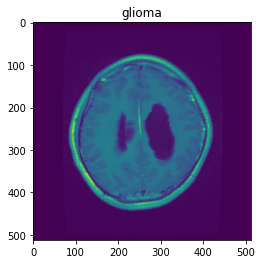

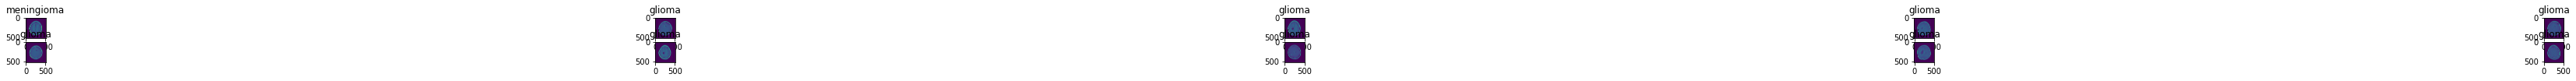

In [ ]:
from PIL import Image

queryIdx = 3 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=10)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[5])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(70,70))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[5]
    plt.title(result_label)
    plt.imshow(image)

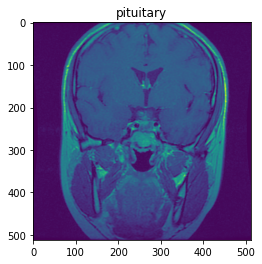

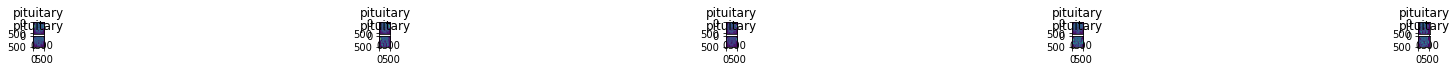

In [ ]:
queryIdx = 480 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=10)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[5])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[5]
    plt.title(result_label)
    plt.imshow(image)

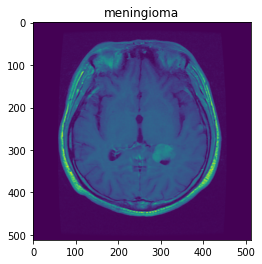

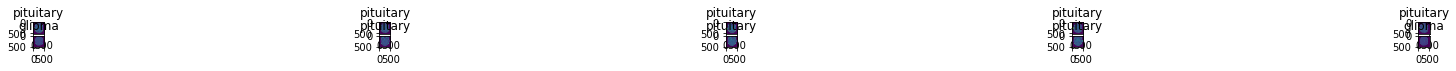

In [ ]:
queryIdx = 334 # Input Index for which images 

queryFeatures = features_retrieved[queryIdx]
results = perform_search(queryFeatures, training_indexed, max_results=10)

imgs = []
result_path = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(dataset_train[j]))
    result_path.append(dataset_train[j])
    imgs.append(img)

# display the query image
plt.title(dataset[queryIdx].split("/")[5])
plt.imshow(np.array(Image.open(dataset[queryIdx])))

plt.figure(figsize=(30,30))
columns = 5
for i, image in enumerate(imgs):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    result_label = result_path[i].split("/")[5]
    plt.title(result_label)
    plt.imshow(image)

In [ ]:
auto_encoder.save('auto_encoder_model.h5')